In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
!unzip 'IMDB Dataset.csv.zip' 

Archive:  IMDB Dataset.csv.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
import nltk 
import re

from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Dropout
from keras.layers import Flatten, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

In [160]:
data = pd.read_csv('IMDB Dataset.csv')
data.isnull().values.any()

False

In [161]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


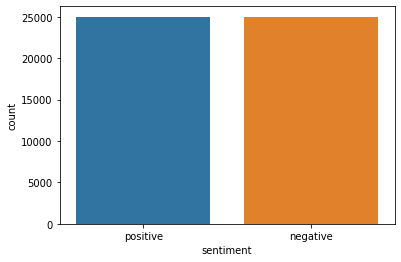

In [162]:
import seaborn as sns
sns.countplot(x="sentiment", data=data)

In [163]:
data["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [164]:
def preprocess_text(sen):
  sentence = remove_tag(sen)
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

In [165]:
Tags = re.compile(r'<[^>]+>')

def remove_tag(text):
  return Tags.sub('',text)

In [166]:
X = []
sentences = list(data['review'])

In [167]:
for sen in sentences:
  X.append(preprocess_text(sen))

In [168]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [169]:
X[2]

'I thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy The plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer While some may be disappointed when they realize this is not Match Point Risk Addiction thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love This was the most d laughed at one of Woody comedies in years dare say decade While ve never been impressed with Scarlet Johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman This may not be the crown jewel of his career but it was wittier than Devil Wears Prada and more interesting than Superman great comedy to go see with friends '

In [170]:
Y = data['sentiment']
Y = np.array(list(map(lambda x: 1 if x=='positive' else 0, Y)))

In [171]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state=42) 

In [172]:
len(x_train)

40000

In [173]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [174]:
vocab_size = len(tokenizer.word_index)+1
maxlen = 100

x_train = pad_sequences(x_train, maxlen=100, padding='post')
x_test = pad_sequences(x_test, maxlen=100, padding='post')

In [175]:
from numpy import zeros
from numpy import asarray
from numpy import array
import zipfile 

In [176]:
ls

 archive.zip        'IMDB Dataset.csv'       kaggle.json   saved_model/
 glove.6B.100d.txt  'IMDB Dataset.csv.zip'   LSTM_model/


In [177]:
!unzip 'archive.zip' 

Archive:  archive.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [178]:
ls

 archive.zip        'IMDB Dataset.csv'       kaggle.json   saved_model/
 glove.6B.100d.txt  'IMDB Dataset.csv.zip'   LSTM_model/


In [179]:
glove_file = open('glove.6B.100d.txt', encoding='utf8')
embedding_dict = dict()

for line in glove_file:
  record = line.split()
  word = record[0]
  vector_dimensions = asarray(record[1:], dtype='float32')
  embedding_dict[word] = vector_dimensions
glove_file.close()

In [180]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [181]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [182]:
!mkdir -p saved_model
model.save('LSTM_model') 

INFO:tensorflow:Assets written to: LSTM_model/assets


In [183]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 90s 349ms/step - loss: 0.6134 - acc: 0.6373 - val_loss: 0.4524 - val_acc: 0.7886
Epoch 2/10
250/250 [==============================] - 87s 346ms/step - loss: 0.4668 - acc: 0.7818 - val_loss: 0.3927 - val_acc: 0.8215
Epoch 3/10
250/250 [==============================] - 86s 346ms/step - loss: 0.3988 - acc: 0.8178 - val_loss: 0.3832 - val_acc: 0.8355
Epoch 4/10
250/250 [==============================] - 86s 345ms/step - loss: 0.3628 - acc: 0.8398 - val_loss: 0.3645 - val_acc: 0.8394
Epoch 5/10
250/250 [==============================] - 87s 347ms/step - loss: 0.3419 - acc: 0.8492 - val_loss: 0.3518 - val_acc: 0.8508
Epoch 6/10
250/250 [==============================] - 86s 346ms/step - loss: 0.3145 - acc: 0.8669 - val_loss: 0.3395 - val_acc: 0.8546
Epoch 7/10
250/250 [==============================] - 87s 347ms/step - loss: 0.2955 - acc: 0.8751 - val_loss: 0.3352 - val_acc: 0.8550
Epoch 8/10
250/250 [==============================] - 8

In [206]:
score = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 10s 32ms/step - loss: 0.3479 - acc: 0.8503


In [207]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34789636731147766
Test Accuracy: 0.8503000140190125


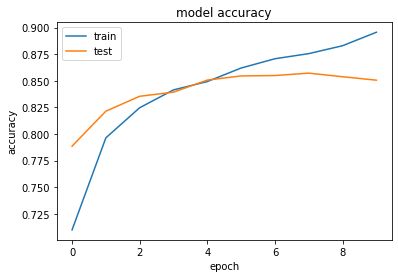

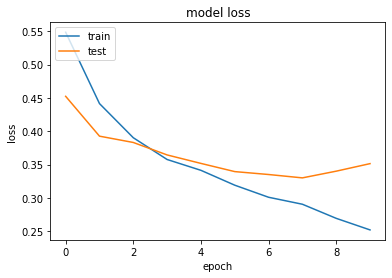

In [208]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [231]:
instance = X[3]
print(instance)

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


In [232]:
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
x = model.predict(instance)
if x>0.5:
  ans = "Positive" 
else:
   ans = "Negative"
print(x)
print(ans)

[[0.2803902]]
Negative
